In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx # NetworkXをインポート
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import seaborn as sns
import scipy
import scipy.stats as st

https://github.com/jeroenvldj/bow-tie_detection

In [2]:
df = pd.read_csv('../networks/TRN.csv')
df.head()


,regulator,gene_name,gene_id,effect,evidence,source,category,regulator_label,Use,regulator_id,prsn_in_gBnb
0,AaeR,aaeA,b3241,+,STRONG,RegulonDB_TF,TF,NaN,NaN,b3243,Yes
1,AaeR,aaeB,b3240,+,STRONG,RegulonDB_TF,TF,NaN,NaN,b3243,Yes
2,AaeR,aaeX,b3242,+,STRONG,RegulonDB_TF,TF,NaN,NaN,b3243,Yes
3,AccB,accB,b3255,-,STRONG,RegulonDB_TF,TF,NaN,NaN,b3255,Yes
4,AccB,accC,b3256,-,STRONG,RegulonDB_TF,TF,NaN,NaN,b3255,Yes


In [3]:
df_reg=df[~df['regulator_id'].str.contains(',')].drop_duplicates(subset='regulator')
df_cmplx=df[df['regulator_id'].str.contains(',')].drop_duplicates(subset='regulator')
df_cmplx=df_cmplx.reset_index()
my_reg=[]
my_bnb=[]
for i in range(len(df_cmplx)):
    for j in range(2):
        my_reg.append(df_cmplx['regulator'][i])
        my_bnb.append(df_cmplx['regulator_id'][i].split(',')[j])
df_cmplx=pd.DataFrame([my_reg,my_bnb],index=['regulator','regulator_id']).T
df_reg=df_reg.loc[:,['regulator','regulator_id']]
df_reg=pd.concat([df_reg,df_cmplx],axis=0)
df_reg=df_reg.reset_index(drop=True)
df_reg

,regulator,regulator_id
0,AaeR,b3243
1,AccB,b3255
2,AcrR,b0464
3,Ada,b2213
4,AdiY,b4116
...,...,...
246,RcsB-BglJ,b4366
247,RelB-RelE,b1563
248,RelB-RelE,b1564
249,YefM-YoeB,b4539


In [15]:
my_reg=[]
my_trg=[]
for i in range(len(df)):
    my_id=df['gene_id'][i]
    df_temp=pd.Series(df_reg['regulator'][df_reg['regulator_id']==my_id]).values.tolist()
    if len(df_temp)==0:
        my_reg.append(df['regulator'][i])
        my_trg.append(df['gene_name'][i])
    else:
        for j in range(len(df_temp)):
            my_reg.append(df['regulator'][i])
            my_trg.append(df_temp[j])
df_net=pd.DataFrame([my_reg,my_trg],index=['regulator','target']).T
df_net=df_net.drop_duplicates()

In [16]:
genes=np.unique([df_net['regulator'],df_net['target']])
regs=set(df_net['regulator'])
edges=df_net['regulator'].str.cat(df_net['target'],sep="\t")

In [17]:
#Create directed graph
net = nx.DiGraph()

for gene in genes:
    net.add_node(gene)
    
for edge in edges:
    lineData = edge.split("\t")
    net.add_edge(lineData[0], lineData[1])
    
count = 0
lsc2 = set()       #2nd LSC
for c in sorted(nx.strongly_connected_components(net),key=len,reverse=True):
    count += 1
    if count == 1:
        core = c     #CORE LAYER
    elif count == 2:
        lsc2 = c
    else:
        break

for node in core:
    dfsd = nx.dfs_successors(net.reverse(),node)
    break

dfsnodesgt = []
for nodes in dfsd.values():
    dfsnodesgt =  dfsnodesgt + nodes
dfsnodesgt = set(dfsnodesgt)
inp = dfsnodesgt - core      #IN LAYER

for node in core:
    dfsd = nx.dfs_successors(net,node)
    break

dfsnodesg = []
for nodes in dfsd.values():
    dfsnodesg = dfsnodesg + nodes
dfsnodesg = set(dfsnodesg)
out = dfsnodesg - core       #OUT LAYER

intendrils  = set()
outtendrils  = set()
tubes = set()
others = set()

for node in net.nodes():     #REMAINING NODES IN TENDRILS, TUBES OR OTHERS LAYERS
    if node in core or node in inp or node in out:
        continue
    dfsd = nx.dfs_successors(net.reverse(),node)
    dfsnodesgt = []
    for nodes in dfsd.values():
        dfsnodesgt = dfsnodesgt + nodes
    dfsnodesgt = set(dfsnodesgt)
    irv = False
    irvval = inp.intersection(dfsnodesgt)
    if len(irvval) != 0:
        irv = True    
    dfsd = nx.dfs_successors(net,node)
    dfsnodes = []
    for nodes in dfsd.values():
        dfsnodes = dfsnodes + nodes
    dfsnodes = set(dfsnodes)
    vro = False
    vroval = out.intersection(dfsnodes)
    if len(vroval) != 0:
        vro = True
    
    if irv and not vro:
        intendrils.add(node)
    elif not irv and vro:
        outtendrils.add(node)
    elif irv and vro:
        tubes.add(node)
    else:
        others.add(node)

In [18]:
#PERCENTAGE OF ALL NODES
print("Size wrt all nodes")
print("CORE size : "+str(len(core)))
print("CORE size % : "+str(len(core)*100.0/len(genes)))
print("2nd LSC size : "+str(len(lsc2)))
print("IN size : "+str(len(inp)))
print("IN size % : "+str(len(inp)*100.0/len(genes)))
print("OUT size : "+str(len(out)))
print("OUT size % : "+str(len(out)*100.0/len(genes)))    
print("INTENDRILS size : "+str(len(intendrils)))
print("INTENDRILS size % : "+str(len(intendrils)*100.0/len(genes)))
print("OUTTENDRILS size : "+str(len(outtendrils)))
print("OUTTENDRILS size % : "+str(len(outtendrils)*100.0/len(genes)))
print("TUBES size : "+str(len(tubes)))
print("TUBES size % : "+str(len(tubes)*100.0/len(genes)))
print("OTHERS size : "+str(len(others)))
print("OTHERS size % : "+str(len(others)*100.0/len(genes)))

print("-------")
#PERCENTAGE OF ALL REGULATORS
corereg = core.intersection(regs)
inpreg = inp.intersection(regs)
outreg = out.intersection(regs)
intendrilsreg = intendrils.intersection(regs)
outtendrilsreg = outtendrils.intersection(regs)
tubesreg = tubes.intersection(regs)
othersreg = others.intersection(regs)
print("Size wrt all regulators")
print("CORE size : "+str(len(corereg)))
print("CORE size % : "+str(len(corereg)*100.0/len(regs)))
print("IN size : "+str(len(inpreg)))
print("IN size % : "+str(len(inpreg)*100.0/len(regs)))
print("OUT size : "+str(len(outreg)))
print("OUT size % : "+str(len(outreg)*100.0/len(regs)))    
print("INTENDRILS size : "+str(len(intendrilsreg)))
print("INTENDRILS size % : "+str(len(intendrilsreg)*100.0/len(regs)))
print("OUTTENDRILS size : "+str(len(outtendrilsreg)))
print("OUTTENDRILS size % : "+str(len(outtendrilsreg)*100.0/len(regs)))
print("TUBES size : "+str(len(tubesreg)))
print("TUBES size % : "+str(len(tubesreg)*100.0/len(regs)))
print("OTHERS size : "+str(len(othersreg)))
print("OTHERS size % : "+str(len(othersreg)*100.0/len(regs)))

Size wrt all nodes
CORE size : 62
CORE size % : 2.132782937736498
2nd LSC size : 3
IN size : 7
IN size % : 0.24079807361541108
OUT size : 2715
OUT size % : 93.3952528379773
INTENDRILS size : 56
INTENDRILS size % : 1.9263845889232887
OUTTENDRILS size : 27
OUTTENDRILS size % : 0.9287925696594427
TUBES size : 3
TUBES size % : 0.10319917440660474
OTHERS size : 37
OTHERS size % : 1.2727898176814585
-------
Size wrt all regulators
CORE size : 62
CORE size % : 26.050420168067227
IN size : 7
IN size % : 2.9411764705882355
OUT size : 133
OUT size % : 55.88235294117647
INTENDRILS size : 0
INTENDRILS size % : 0.0
OUTTENDRILS size : 27
OUTTENDRILS size % : 11.344537815126051
TUBES size : 3
TUBES size % : 1.2605042016806722
OTHERS size : 6
OTHERS size % : 2.5210084033613445


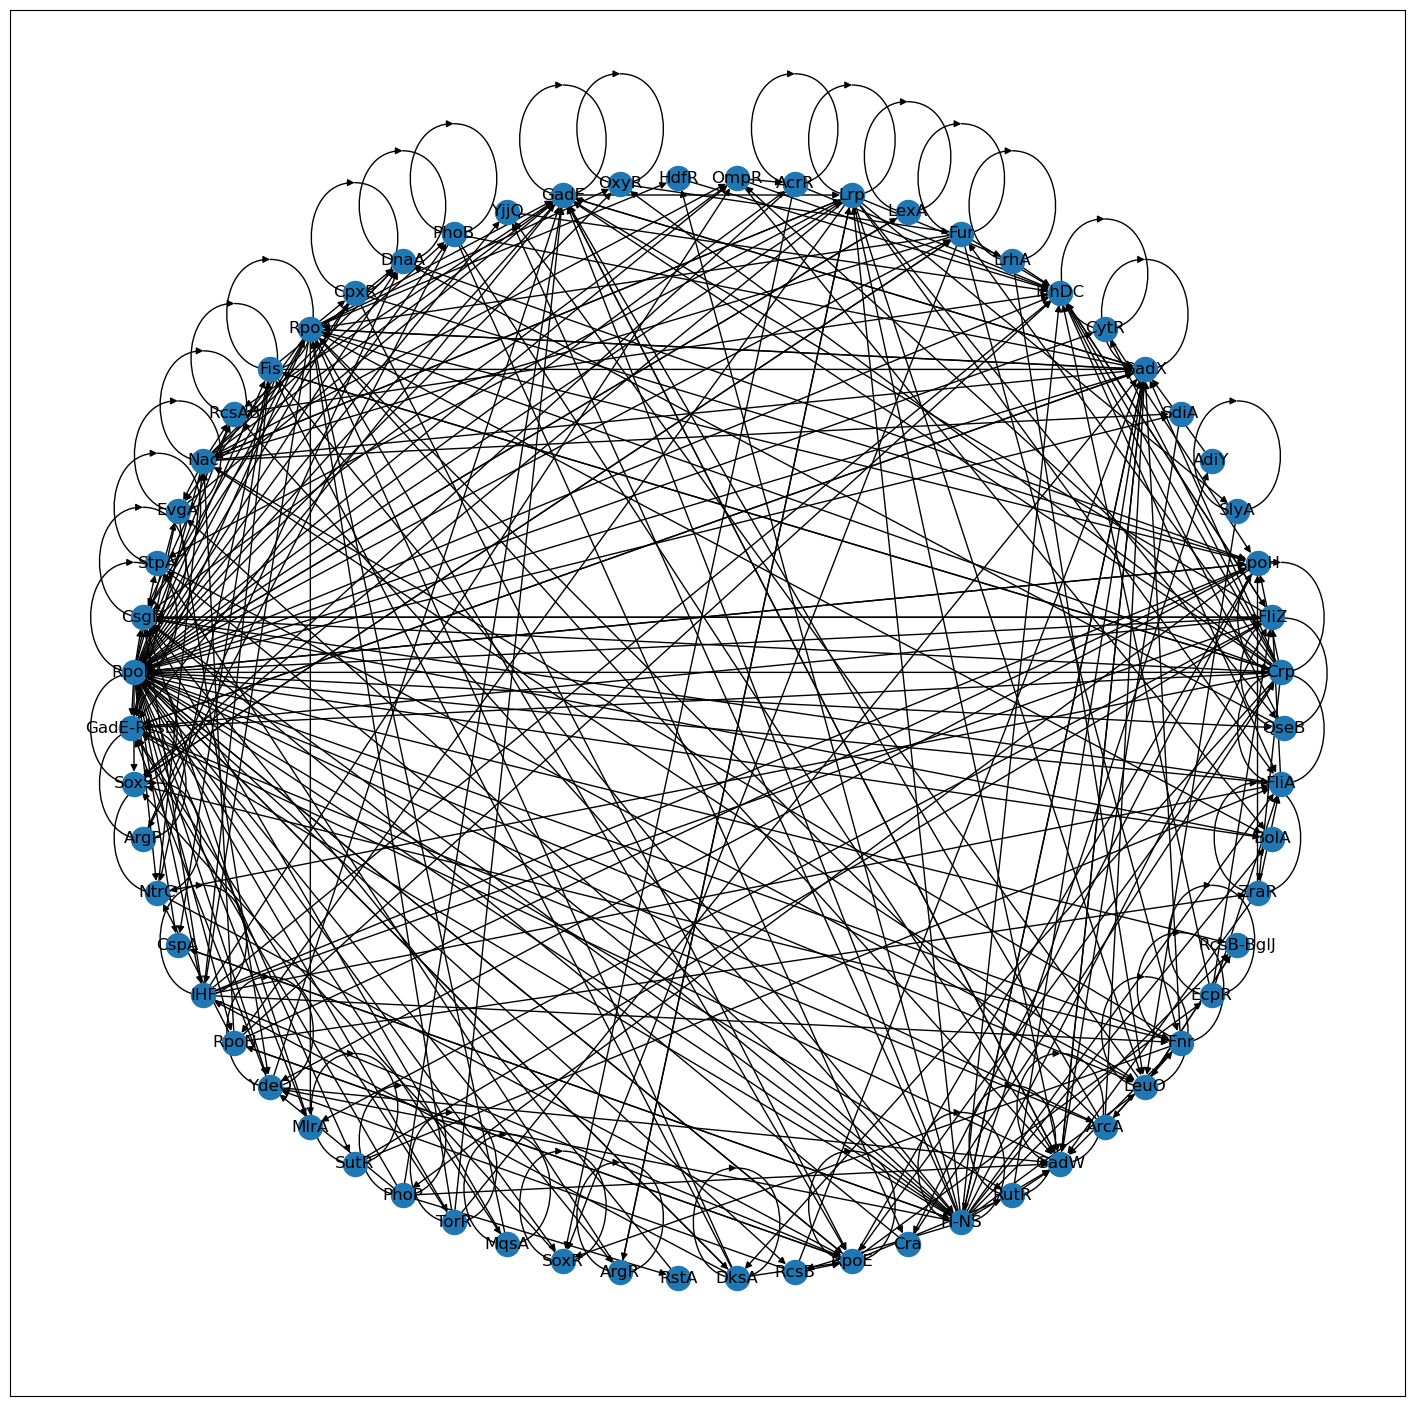

In [20]:
net_scc=nx.subgraph(net, core)
pos=nx.circular_layout(net_scc)
plt.figure(figsize=(18,18))
nx.draw_networkx(net_scc,pos=pos)

# Output

In [21]:
temp=nx.to_pandas_edgelist(net_scc)
temp.to_csv("../output/nx_network_scc.csv",index=False)
temp=nx.to_pandas_edgelist(net)
temp.to_csv("../output/nx_network_all.csv",index=False)
df_reg.to_csv("../output/regulators.csv",index=False)
df_net.to_csv("../output/regulators_target.csv",index=False)

In [35]:
temp=pd.DataFrame(core)
temp.to_csv("../output/core.csv",index=False,header=False)
temp=pd.DataFrame(inp)
temp.to_csv("../output/inp.csv",index=False,header=False)
temp=pd.DataFrame(out)
temp.to_csv("../output/out.csv",index=False,header=False)
temp=pd.DataFrame(intendrils)
temp.to_csv("../output/intendrils.csv",index=False,header=False)
temp=pd.DataFrame(outtendrils)
temp.to_csv("../output/outtendrils.csv",index=False,header=False)
temp=pd.DataFrame(tubes)
temp.to_csv("../output/tubes.csv",index=False,header=False)
temp=pd.DataFrame(others)
temp.to_csv("../output/others.csv",index=False,header=False)